In [1]:
import os
os.chdir('/Users/nick/Documents/school/research/EfficientLPR')
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import svm
from rapidfuzz import fuzz
import pickle
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from tqdm import trange

In [2]:
def get_l2_norm(y_trues, y_preds):
    distances = []
    for i in range(len(y_preds)): # calculate euclidian distance between preds and answer
        y_true, y_pred = y_trues[i], y_preds[i]
        distances.append(np.linalg.norm(y_true - y_pred))
    return np.expand_dims(distances,1)

def get_lev_distance(y_true, y_preds):
    lev_distances = []
    for row in np.hstack([np.expand_dims(y_preds, 1), np.expand_dims(y_true, 1)]):
        lev_distances.append(fuzz.ratio(row[0], row[1]))
    return np.expand_dims(lev_distances,1)

In [83]:
"""
Script that transforms the predictions into three features:
    lp_distance: a similarity metric representing the levenshtein distance between true and predicted LP
    body_distance: distance between true and predicted body
    color_distance: distance between true and predicted color

"""
test = True
normalize = True

predictions_path = f'predictions_nzvd_{"test" if test else "train"}.full.csv'
trues_path = f'data/processed/nzvd/{"test" if test else "train"}_annotations.csv'
lps_path = f'data/raw/nzvd/{"test" if test else "train"}_labels.csv'
classes_path = 'data/processed/classes.csv'
colors_path = 'data/processed/colors.csv'

# get class data
classes = [x[0] for x in pd.read_csv(classes_path, header=None).values]
colors = [x[0] for x in pd.read_csv(colors_path, header=None).values]
class_labels = {x:i for i,x in enumerate(classes)}
color_labels = {x:i for i,x in enumerate(colors)}

# get y_pred 
preds = pd.read_csv(predictions_path)
preds = preds.fillna('') # fill NaN values with empty string

# get y_true
lps = pd.read_csv(lps_path)[['lp-string']].T.squeeze()
lps = lps.apply(lambda x: str(x).replace(' ', ''))
trues = pd.read_csv(trues_path, header=None)
if 'train' in trues_path:
    trues = pd.concat([trues, pd.read_csv(trues_path.replace('train', 'val'), header=None)])
trues.columns = ['file', 't', 'l', 'h', 'w', 'body', 'color']
trues = trues.sort_values(by=['file'])
trues.reset_index(inplace=True)
trues = trues.assign(lp=lps)


# LICENSE PLATES    
lp_true, lp_pred = trues[['lp']].values.squeeze(), preds[['lp']].values.squeeze()
lp_acc = np.mean([lp_true == lp_pred])
print("LP Exact Accuracy:", f'{lp_acc}%', )

def featurize(trues, preds):
    """Converts [preds, true] into [levenshtein distance, CCE_body, CCE_color]"""

    # levenshtein distance of license plates
    lev_distances = get_lev_distance(trues[['lp']].values.squeeze(), preds[['lp']].values.squeeze())

    # BODY
    body_true = list(map(lambda x: class_labels[x], trues[['body']].values.squeeze().tolist()))
    body_true = tf.one_hot(body_true, depth=len(class_labels))
    body_headers = [header for header in preds.columns if header.startswith('body')]
    body_pred = preds[body_headers].values
    body_cce = np.expand_dims(tf.losses.categorical_crossentropy(body_true, body_pred).numpy(), 1)


    # COLOR
    color_true = list(map(lambda x: color_labels[x], trues[['color']].values.squeeze().tolist()))
    color_true = tf.one_hot(color_true, depth=len(color_labels))
    color_headers = [header for header in preds.columns if header.startswith('color')]
    color_pred = preds[color_headers].values
    color_cce = np.expand_dims(tf.losses.categorical_crossentropy(color_true, color_pred).numpy(), 1)

    color_score = 1/(color_cce + 1)
    body_score = 1/(body_cce + 1)

    return [100-lev_distances, color_cce, body_cce] #full
    # return [lev_distances/100, color_score] # ablate body
    # return [lev_distances/100, body_score] # ablate color
    # return [lev_distances/100] # ablate both
    
y_positive = np.expand_dims(np.repeat([1], len(preds)), 1) # positive samples have class==1
x_positive = np.hstack(featurize(trues, preds))
x_negative = np.empty((0,x_positive.shape[1]))
y_negative = np.empty((0,1))

# create negatives
for i, sample in enumerate(trues.iloc):
    """ Create negative samples. For each true sample, pair with every non-matching sample """
    headers = sample.index.values
    neg_true = [sample.values for _ in range(len(trues)-1)]
    neg_true = pd.DataFrame(neg_true, columns=headers)
    # add all preds except current sample
    neg_pred = pd.concat([preds.iloc[:i], preds.iloc[i+1:]])
    neg_x = featurize(neg_true, neg_pred)
    neg_x = np.hstack(neg_x)
    neg_y = np.zeros((len(neg_x), 1))

    x_negative = np.concatenate([x_negative, neg_x])
    y_negative = np.concatenate([y_negative, neg_y])

x_negative = np.array(x_negative)
y_negative = np.array(y_negative)
# balance data
neg_idxs = np.random.randint(0, len(x_positive), len(x_positive))
x_negative = x_negative[neg_idxs]
y_negative = y_negative[neg_idxs]

scaler = MinMaxScaler()
x = np.vstack([x_positive, x_negative])
y = np.vstack([y_positive, y_negative])

if normalize:
    x = scaler.fit_transform(x)
    y = scaler.fit_transform(y)

print('+ve mean', np.mean(x_positive, axis=0))
print('+ve std', np.std(x_positive, axis=0))
print('-ve mean', np.mean(x_negative, axis=0))
print('-ve std', np.std(x_negative, axis=0))

LP Exact Accuracy: 0.74%
+ve mean [6.71717172 2.00462905 1.44303702]
+ve std [15.19979178  3.80331206  2.18727547]
-ve mean [82.79393939  2.05200832  5.55841031]
-ve std [13.17123086  2.18566174  6.45041738]


In [100]:
import joblib
if not test:
    log = LogisticRegression()
    log = log.fit(x, y)
    joblib.dump(log, 'logistic.joblib')
else:
    log = joblib.load('logistic.joblib')

score_accs = []
unmatched = []



# iterate over predictions, comparing each pred against whole GT database
# if system works, the i-th GT entry should be the max fit
for i, prediction in enumerate(preds.iloc):
    # initialize y_array
    y_true = np.zeros(len(trues))
    # set single true match
    y_true[i] = 1
    # repeat sample
    colnames = prediction.index.values
    prediction = prediction.values
    x_pred = [prediction for _ in range(len(trues))]
    x_pred = pd.DataFrame(x_pred, columns=colnames)

    # compare sample against all samples
    x_pred = featurize(trues, x_pred)
    x_pred = np.hstack(x_pred)


    if normalize:
        x_pred = scaler.transform(x_pred)

    score = log.predict_proba(x_pred)[:,1]
    imax = np.argmax(score)

    score_accs.append(y_true[imax] == 1)

    pred_lp = prediction[-1]
    true_lp = trues.iloc[i][['lp']].values[0]
    fname = trues.iloc[i][['file']].values[0]

    if not y_true[imax] == 1:
        unmatched.append([fname, pred_lp, true_lp])

    
print('Matched', np.mean(score_accs)*100, '%')
print(log.coef_[0])
print('Unmatched instances:', len(unmatched))
print(np.array(unmatched))

Matched 98.0 %
[-6.79595147 -1.07047505 -2.46767592]
Unmatched instances: 2
[['test/429.jpg' 'J66' 'UA7896']
 ['test/440.jpg' '' 'KQ2057']]


In [102]:
threshold = 0.5

prec = tf.metrics.Precision()
rec = tf.metrics.Recall()
acc = tf.metrics.Accuracy()

for x_, y_ in zip(x, y):
    if log.predict_proba(np.expand_dims(x_, 0))[0,1] > threshold:
        p = 1
    else:
        p = 0
    prec.update_state(y_,[p])
    rec.update_state(y_,[p])
    acc.update_state(y_,[p])
    if not p == y_:
        print(x_, y_)
print('Precision', prec.result().numpy())
print('Recall', rec.result().numpy())
print('Accuracy', acc.result().numpy())

[0.77777778 1.         0.07367608] [1.]
[1.         0.00164642 0.10917577] [1.]
[0.5        0.0625329  0.11017446] [0.]
[0.5        0.0625329  0.11017446] [0.]
Precision 0.98
Recall 0.98
Accuracy 0.98


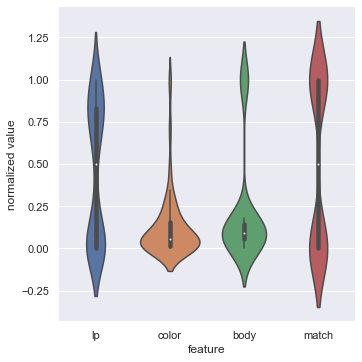

In [127]:
import seaborn as sns
sns.set()

d = pd.DataFrame(np.hstack([x,y]))
ax = sns.catplot(data=d, kind="violin")
ax.set_xticklabels(['lp', 'color', 'body', 'match'])
ax.set(xlabel='feature', ylabel='normalized value')
# THIS GRAPH SHOWS HOW CATEGORICAL CROSS-ENTROPY IS USEFUL OVER MATCHING ACCURACY
# BINARY MATCH == LESS INFORMATION

# Ignore below 

In [66]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

scores = []

# step 1: assuming body == color weighting, adjust LP weighting to find highest accuracy
k_values = np.linspace(0, 5, 51)
for j in k_values:
    score_accs = []

    # compare each prediction against entire GT "database"
    for i, prediction in enumerate(preds.iloc):
        # initialize y_array
        y_true = np.zeros(len(trues))
        # set single true match
        y_true[i] = 1
        # repeat sample
        colnames = prediction.index.values
        prediction = prediction.values
        x_pred = [prediction for _ in range(len(trues))]
        x_pred = pd.DataFrame(x_pred, columns=colnames)

        # compare sample against all samples
        x_pred = featurize(trues, x_pred)
        x_pred = np.hstack(x_pred)

        score = similarity(x_pred, [j, 1, 1])
        imax = np.argmax(score)
        score_accs.append(y_true[imax] == 1)
    scores.append(np.mean(score_accs))

In [71]:
k=2.8 # best k factor

# step 2: see which threshold gets optimal accuracy
thresholds = np.linspace(0, k, k*10+1)
metrics = np.zeros(shape=(len(thresholds), 3))

for threshold in thresholds:
    prec = tf.metrics.Precision()
    rec = tf.metrics.Recall()
    acc = tf.metrics.Accuracy()
    for x_, y_ in zip(x, y):
        if similarity(x_, [k, 1, 1]) > threshold:
            prec.update_state(y_,[1])
            rec.update_state(y_,[1])
            acc.update_state(y_,[1])
        else:
            prec.update_state(y_,[0])
            rec.update_state(y_,[0])
            acc.update_state(y_,[0])
    index = int(threshold*10)
    metrics[index,0] = prec.result().numpy()
    metrics[index,1] = rec.result().numpy()
    metrics[index,2] = acc.result().numpy()

In [93]:
# step 3: establish impact of color and body, need to compare against many thresholds
thresholds = np.linspace(0,5,51)
res = np.zeros(shape=(len(thresholds),2,2))

for threshold in thresholds:
    for b_color in [0,1]:   
        for b_body in [0,1]:
            prec = tf.metrics.Precision()
            rec = tf.metrics.Recall()
            acc = tf.metrics.Accuracy() 
            for x_, y_ in zip(x, y):
                if similarity(x_, [k, b_color, b_body]) > threshold:
                    prec.update_state(y_,[1])
                    rec.update_state(y_,[1])
                    acc.update_state(y_,[1])
                else:
                    prec.update_state(y_,[0])
                    rec.update_state(y_,[0])
                    acc.update_state(y_,[0])
            res[int(threshold*10), b_color, b_body] = acc.result().numpy()

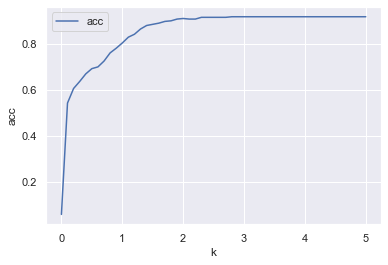

Score acc maximized at: 2.8
acc    0.916456
Name: 28, dtype: float64


In [69]:
scores_df = pd.DataFrame(scores, columns=['acc'])

ax = sns.lineplot(data=scores_df)
ax.set(xlabel='k', ylabel='acc')
ax.set_xticklabels([0,0, 1, 2, 3, 4, 5])
plt.show()
i_max_score = np.argmax(scores_df["acc"])
print('Score acc maximized at:', i_max_score/10)
print(scores_df.iloc[i_max_score])

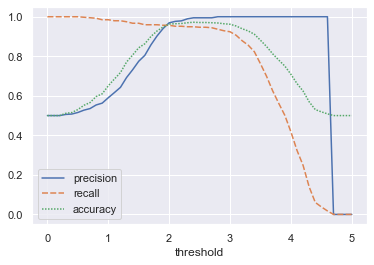

Max acc idx: 2.4
precision    0.994695
recall       0.949367
accuracy     0.972152
Name: 24, dtype: float64


In [72]:
metrics_df = pd.DataFrame(metrics, columns=['precision', 'recall', 'accuracy'])
ax = sns.lineplot(data=metrics_df)
ax.set_xticklabels([0,0,1,2,3,4,5])
ax.set(xlabel="threshold")
plt.show()
i_max_acc = np.argmax(metrics_df["accuracy"])
print('Max acc idx:', i_max_acc/10)
print(metrics_df.iloc[i_max_acc])

In [109]:
# illustrate influence of the ancillary features
# (0,0) cell shows accuracy without body and color
for confusion in res:
    print(confusion[1,1], confusion[0,0])
res_df = pd.DataFrame(res)
sns.heatmap(data=res, annot=True)

0.5 0.5987342000007629
0.5 0.5987342000007629
0.5 0.5987342000007629
0.5063291192054749 0.5987342000007629
0.5151898860931396 0.5987342000007629
0.5265823006629944 0.8037974834442139
0.5417721271514893 0.8227847814559937
0.5594936609268188 0.8240506052970886
0.5848101377487183 0.8265822529792786
0.6050633192062378 0.8291139006614685
0.648101270198822 0.948101282119751
0.6835442781448364 0.9531645774841309
0.7367088794708252 0.9518987536430359
0.7886075973510742 0.9518987536430359
0.8177215456962585 0.9721518754959106
0.850632905960083 0.9721518754959106
0.8708860874176025 0.9708860516548157
0.9088607430458069 0.9696202278137207
0.9253164529800415 0.9696202278137207
0.945569634437561 0.9582278728485107
0.9620253443717957 0.9582278728485107
0.9607595205307007 0.9569620490074158
0.9645569324493408 0.9569620490074158
0.9734176993370056 0.9544304013252258
0.9746835231781006 0.8607594966888428
0.9734176993370056 0.8594936728477478
0.9734176993370056 0.8455696105957031
0.9721518754959106 0.84

ValueError: Must pass 2-d input